## ISYE 6402, M 2.4 - IBM Stock Price Prediction Example

International Business Machines (IBM): Four companies came to form the Computing Tabulating Recording Company in 1911 which later became IBM in 1933. What are important events after 1960?
- 1964: the first computer system family;
- 1974: UPC was developed
- 1981: financial swaps (in collaboration with Word Bank)
- 1993: US$8 billion loss
- 2005: selling personal computing business
- 2014: selling x86 server division
- 2015: acquiring Merge Healthcare & Weather Company
- 2016: acquiring Truven


**Stock Price:**
- Perceived company’s worth
- Multiplied by number of shares give the total company’s worth
- Affected by a number of things including volatility in the market, current economic conditions, and popularity of the company 

**Study Objective**
- Develop a model to predict IBM stock price given that no major events are to be released

**Time Series Data**
- Daily stock price from January 29th 1962 until August 26 th 2020
- High, Low, Close, Adj.Close

In [1]:
library(ggplot2)

In [2]:
ibmdata = read.table("IBMstockpriceNew.txt",header=T,sep = ',')
head(ibmdata)

,Date,Open,High,Low,Close,Adj.Close,Volume
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1962-01-29,7.216667,7.266667,7.093333,7.093333,1.746444,579200
2,1962-01-30,7.093333,7.133333,7.003334,7.003334,1.724285,736000
3,1962-01-31,7.073333,7.226666,7.073333,7.226666,1.779273,760000
4,1962-02-01,7.300000,7.413333,7.300000,7.393333,1.820308,640000
5,1962-02-02,7.393333,7.440000,7.360000,7.440000,1.831797,507200
6,1962-02-05,7.440000,7.440000,7.306667,7.346667,1.808818,312000


In [3]:
# use the as.date() command in R to convert the date, providing the data into a date object in R
# For this command, the input is the vector of dates converted into character with the 
# specification on how the dates are recorded
#ibm.date = as.Date(as.character(ibmdata$Date), format="%m/%d/%Y")
ibm.date = as.Date(as.character(ibmdata$Date), format="%Y-%m-%d")
ibmdata$Date = ibm.date
attach(ibmdata)

head(ibmdata)

,Date,Open,High,Low,Close,Adj.Close,Volume
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1962-01-29,7.216667,7.266667,7.093333,7.093333,1.746444,579200
2,1962-01-30,7.093333,7.133333,7.003334,7.003334,1.724285,736000
3,1962-01-31,7.073333,7.226666,7.073333,7.226666,1.779273,760000
4,1962-02-01,7.300000,7.413333,7.300000,7.393333,1.820308,640000
5,1962-02-02,7.393333,7.440000,7.360000,7.440000,1.831797,507200
6,1962-02-05,7.440000,7.440000,7.306667,7.346667,1.808818,312000


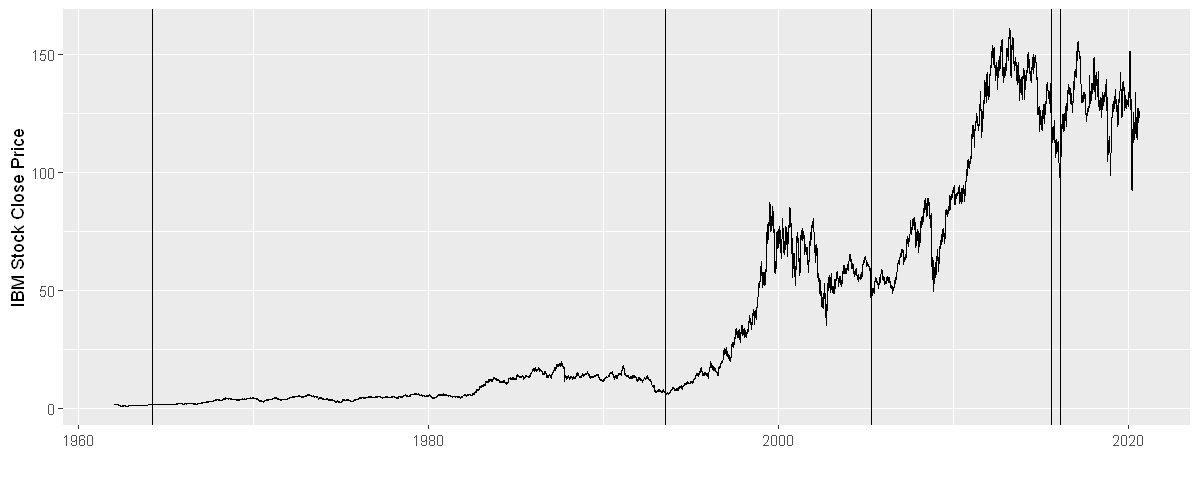

In [4]:
options(repr.plot.width=10, repr.plot.height=4)

## Dates: April 7 1964, 27 July 1993, May 1 2005, Aug 5 2015, Feb 18 2016
ficom = which(Date=="1964-04-07")
loss = which(Date=="1993-07-27")
lenovo = which(Date=="2005-05-02")
healthm = which(Date=="2015-08-05")
truven = which(Date=="2016-02-18")
alldates = c(ficom,loss,lenovo,healthm,truven)

# ggplot command with inputs, the date and the adjusted closed price, to plot the time series along with the 
# vertical lines indicating the event acquisition of Truven in 2016, and also other events as provided in the plot. 
# The vertical lines for all other events are added similarly as for Truven.
ggplot(ibmdata, aes(Date, Adj.Close)) + geom_line() + xlab("") + ylab("IBM Stock Close Price")+
geom_vline(xintercept = as.numeric(Date[alldates]))

There are several characteristics to point out. 

- The trend is overall monotone, increasing with fluctuations in the later decades. 

- There is no clear seasonality that can be evaluated visually. 

- However, we can note the heteroscedasticity or non-constant variance of the time series. The variability in the stock price clearly shows a big change from being significantly smaller in the early years versus much larger in later years. 

- We also note that the events did not clearly trigger significant changes at least as seen on this scale. For earlier events it is hard to distinguish any differences because of the difference in scale. The price is low with low volatility around 1995 with more distinguishable changes thereafter.

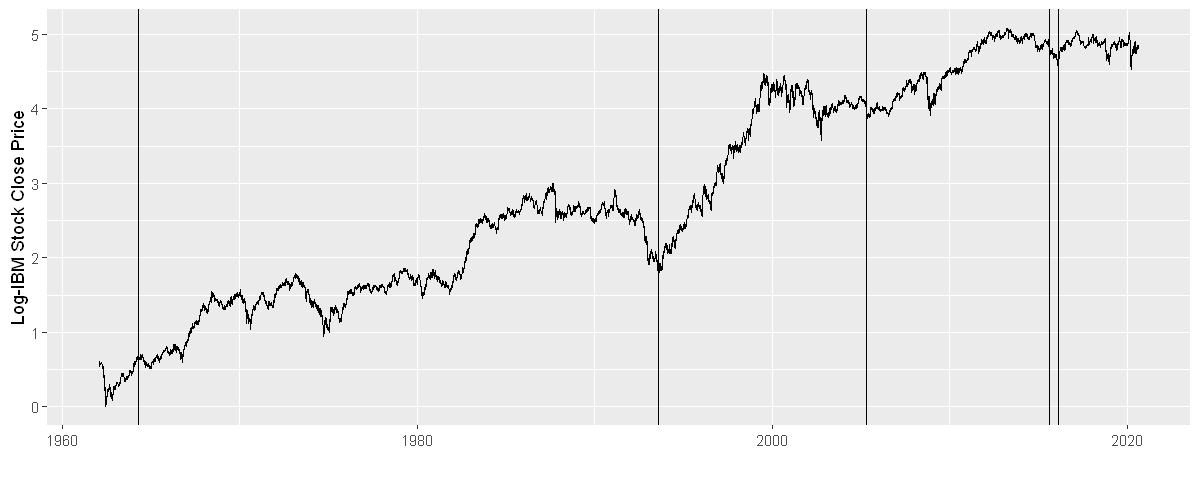

In [5]:
## IBM Stock Price: Non-constant variance => Transform
AdjClose.tr = log(Adj.Close)
ggplot(ibmdata, aes(Date, AdjClose.tr)) + geom_line() + xlab("") + ylab("Log-IBM Stock Close Price")+
geom_vline(xintercept = as.numeric(Date[alldates]))

**In fact, in order to better distinguish patterns throughout the entire time period, it is a good idea to use a transformation that stabilizes the variance and amplifies local patterns such as the log transformation.**

- On the log scale, the patterns in the earlier years are much easier to distinguish. 

- For example, we can see the increase in the stock price after the first family computer was launched in 1964. 

- And we also see a significant drop in the price when the company had a very large loss in 1993. 

- The merger and acquisition in 2015 and 2016 are followed by an increase in the stock price.

### Assessing Dependence & Stationarity

- One way to account for the trend is to consider the difference process

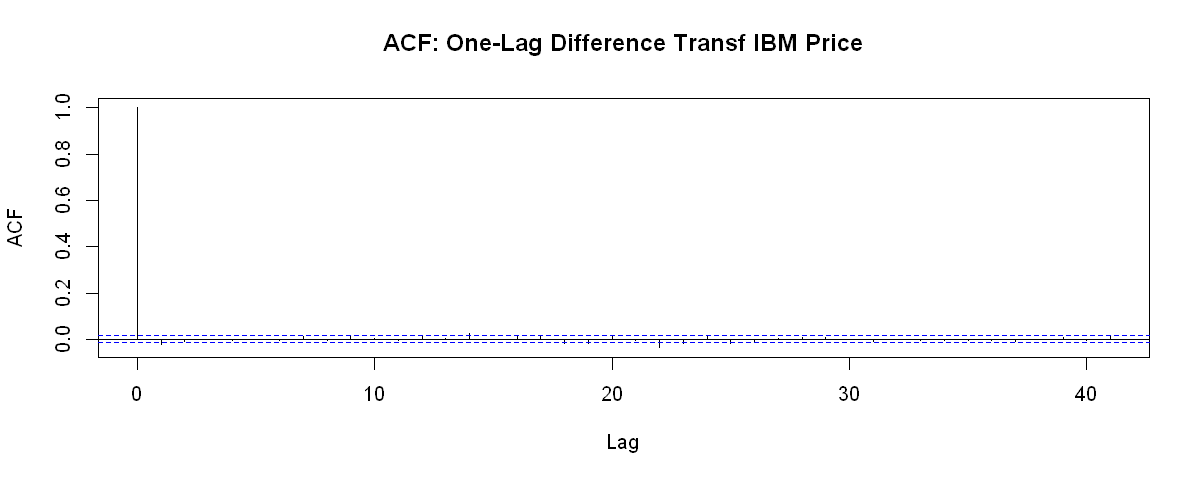

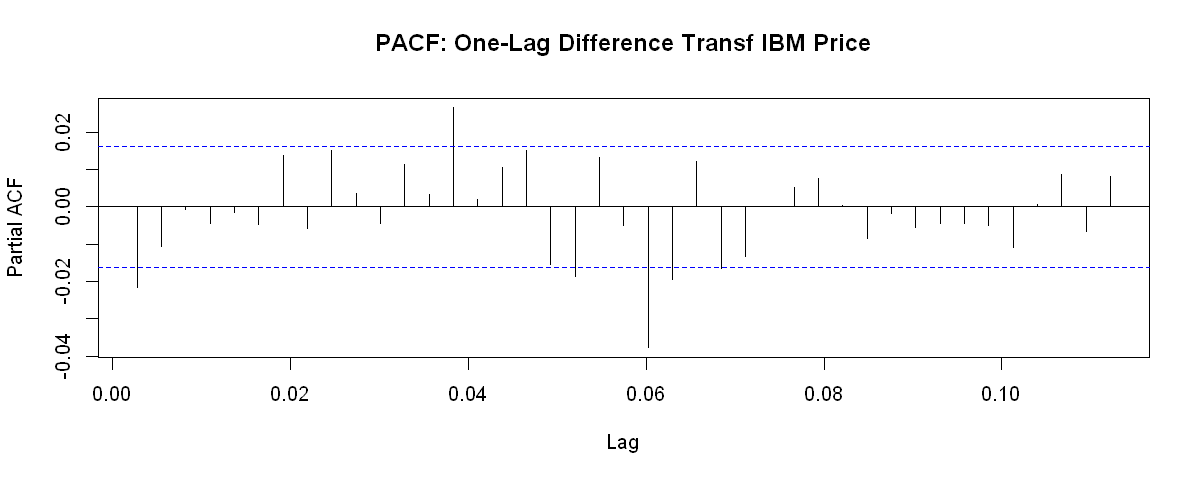

In [6]:
# redefine the stock price as the time series with a frequency specifying daily data starting with January 29th, 1962
ts.price = ts(AdjClose.tr,start=c(1962,1,29),frequency=365.25)
## Differencing to Remove Trend
# Then I used a difference command to take the difference, where the default in this command is the first order difference.
diff.ts.price = diff(ts.price)

# I also plotted the ACF and PACF to see whether another difference of the data is needed 
# and/or whether the resulting process is stationary
acf(as.vector(diff.ts.price),main="ACF: One-Lag Difference Transf IBM Price")
pacf(diff.ts.price,main="PACF: One-Lag Difference Transf IBM Price")

- The two plots look just like those for the white noise.

**Do we still then, need to apply an ARMA model to model the difference process, or is it enough to take the difference since the difference process seems to look like white noise?**

### ARIMA Modeling

- Next, I applied the ARIMA modelling. I used ARIMA to take into account the trend through differencing. 

- I assume only one order difference and thus set the difference order equal to one. 

- Here I only selected the orders of the AR and MA polynomials using the AICc criterion. 

- For this we need to fit the ARMA model for all combinations of AR and MA orders up to the maximum order for both polynomials. 

- Here I set the maximum order to be five, and consider orders from zero to five for both the AR and MA components

- I loop over all combinations of the orders and fit the ARMA model for all those combinations and save the AICC values in a matrix for all the combinations.

- Note that the R implementation does not provide the AICC value but the AIC without the modification.

- The selected orders are p equal to 0 and q equal to 1. Last, we fit the model for the selected orders called here, the final model.

In [7]:
## Apply ARIMA

## Order selection -- AIC 
n = length(ts.price)
norder = 6
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)

for(i in 1:norder){
   for(j in 1:norder){
    modij = arima(ts.price,order = c(p[i],1,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
   }  
}

aicv = as.vector(aic)  
indexp = rep(c(1:norder),norder)
indexq = rep(c(1:norder),each=norder)
indexaic = which(aicv == min(aicv))
porder = indexp[indexaic]-1
qorder = indexq[indexaic]-1

final_model = arima(ts.price, order = c(porder,1,qorder), method = "ML")

### ARIMA Modeling: Residual Analysis

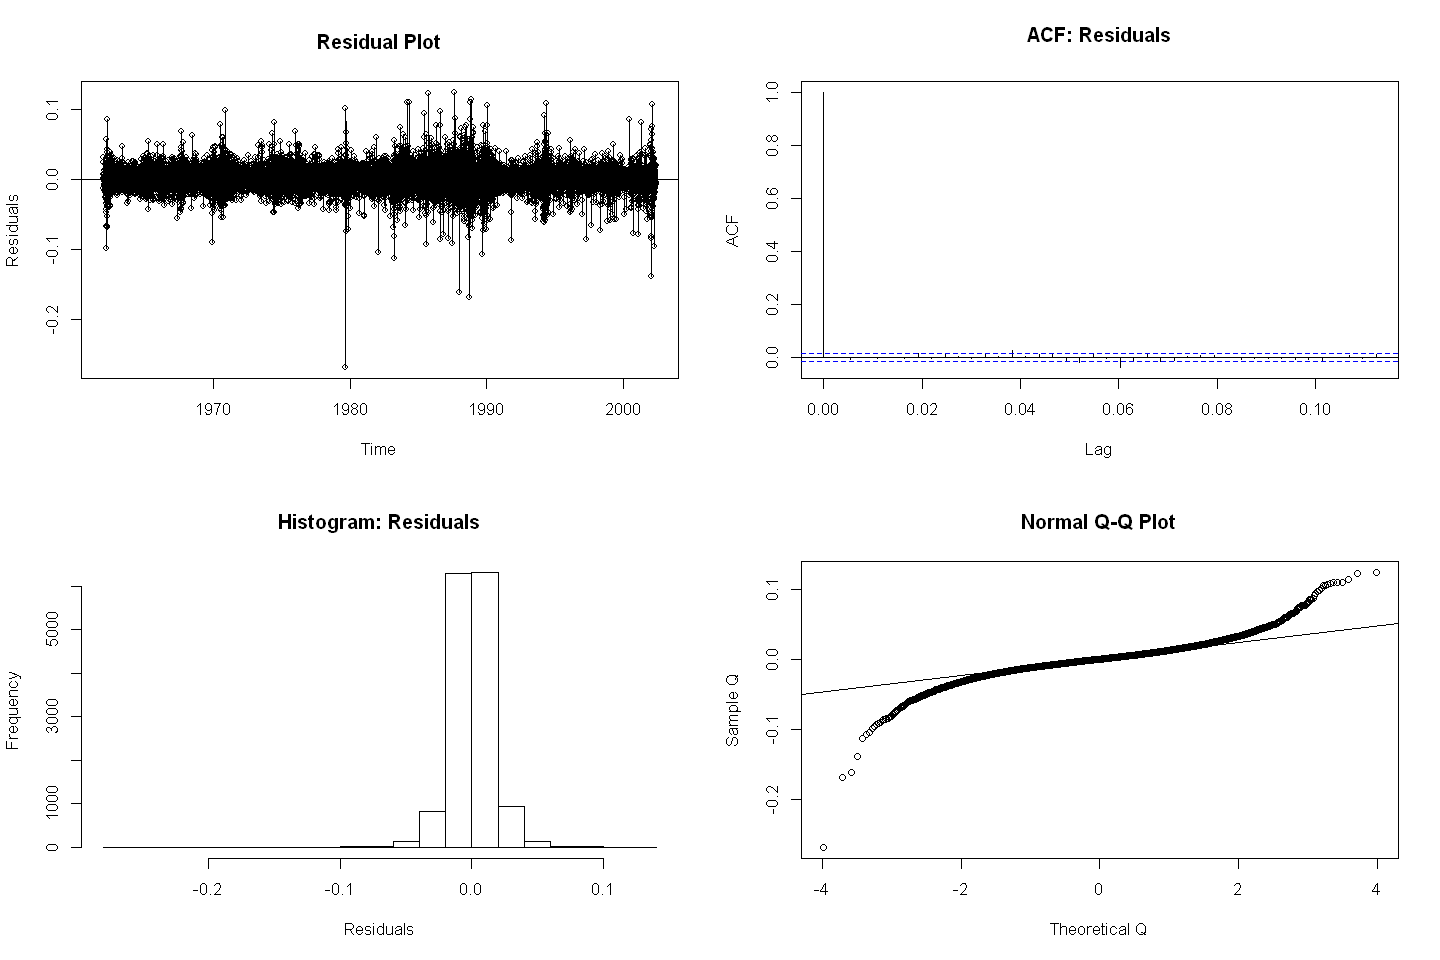

In [8]:
options(repr.plot.width=12, repr.plot.height=8)

## GOF: residual analysis
par(mfrow=c(2,2))
plot(resid(final_model), ylab='Residuals',type='o',main="Residual Plot")
abline(h=0)
acf(resid(final_model),main="ACF: Residuals")
hist(resid(final_model),xlab='Residuals',main='Histogram: Residuals')
qqnorm(resid(final_model),ylab="Sample Q",xlab="Theoretical Q")
qqline(resid(final_model))

Here are the residual plots for the fitted ARMA Model. 

- The residual plot does not show to have a pattern. The variance of the residuals is also constant. 
- The ACF plot has only the first lag equal to one, where all other values for the sample ACF are small within the confidence band. 
- The same for the sample PACF, the values are all within the confidence band. **(not plotted!)**
- The Q-Q normal plot shows both a left and a right tail, an indication that the residuals may have more of a T distribution than a normal distribution, although otherwise quite symmetric.

### Testing for Uncorrelated Residuals

- Last, we also apply the hypothesis testing procedures for independence or serial correlation using the Box-Pierce and Ljung-Box test. 
- The R output of these implementation is here.
- In this implementation, we need to input the lag for the test statistic and fitdf for the distribution under the null hypothesis. 
- Here I used the lag to be equal to the sum of the AR and MA order plus 1 and the degree of freedom of the fitted model to be the sum of the two orders. 
- It is common practice to use a minimum lag for the test to be as provided by the sum of the orders plus 1.

- The R output provides the test values along with the p-value of the test. 
- **Note that the null hypothesis in this test is that the time series process (here it is the residual process) consists of uncorrelated variables.**

- **Thus, this is one case when we want large P values so that we do not reject the null hypothesis.**

In [9]:
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Box-Pierce", fitdf = (porder+qorder))
Box.test(final_model$resid, lag = (porder+qorder+1), type = "Ljung-Box", fitdf = (porder+qorder))


	Box-Pierce test

data:  final_model$resid
X-squared = 1.5201, df = 1, p-value = 0.2176



	Box-Ljung test

data:  final_model$resid
X-squared = 1.5206, df = 1, p-value = 0.2175


**The P values for both tests are large, indicating that it is plausible for the residuals to be uncorrelated.**

### ARIMA Forecasting

- We'll first implement and evaluate a 10-days ahead prediction for the **log-transformed stock price**. 
- For this, I set apart the last 10 days of the time series, fit the model based on a time series discarding the last 10 days, - - and then predict the last 10 days to compare with the observed values of the time series for these 10 days. 
- **The predict command in R takes as an input the ARMA object along with the number of lags for the prediction.** 
- The prediction provides the predicted time series values, along with point-wise confidence intervals for the prediction.
- Here I also plotted the time series data along with predicted values and the confidence band. 
- I did not plot the entire history of the time series, but only the last 50 days of the time series. 
- I overlayed the predicted values in red along with the confidence band in blue. 
- Note that when I plotted the data along with the predictions, **I transformed them back using the exponential function since here we predicted the log of the stock price, and not the stock price itself**. 
- Thus, for evaluating the predictions of the stock price we need to transform back with the inverse of the log function, the exponential. The same exponential transformation is applied to the lower and the upper bounds.

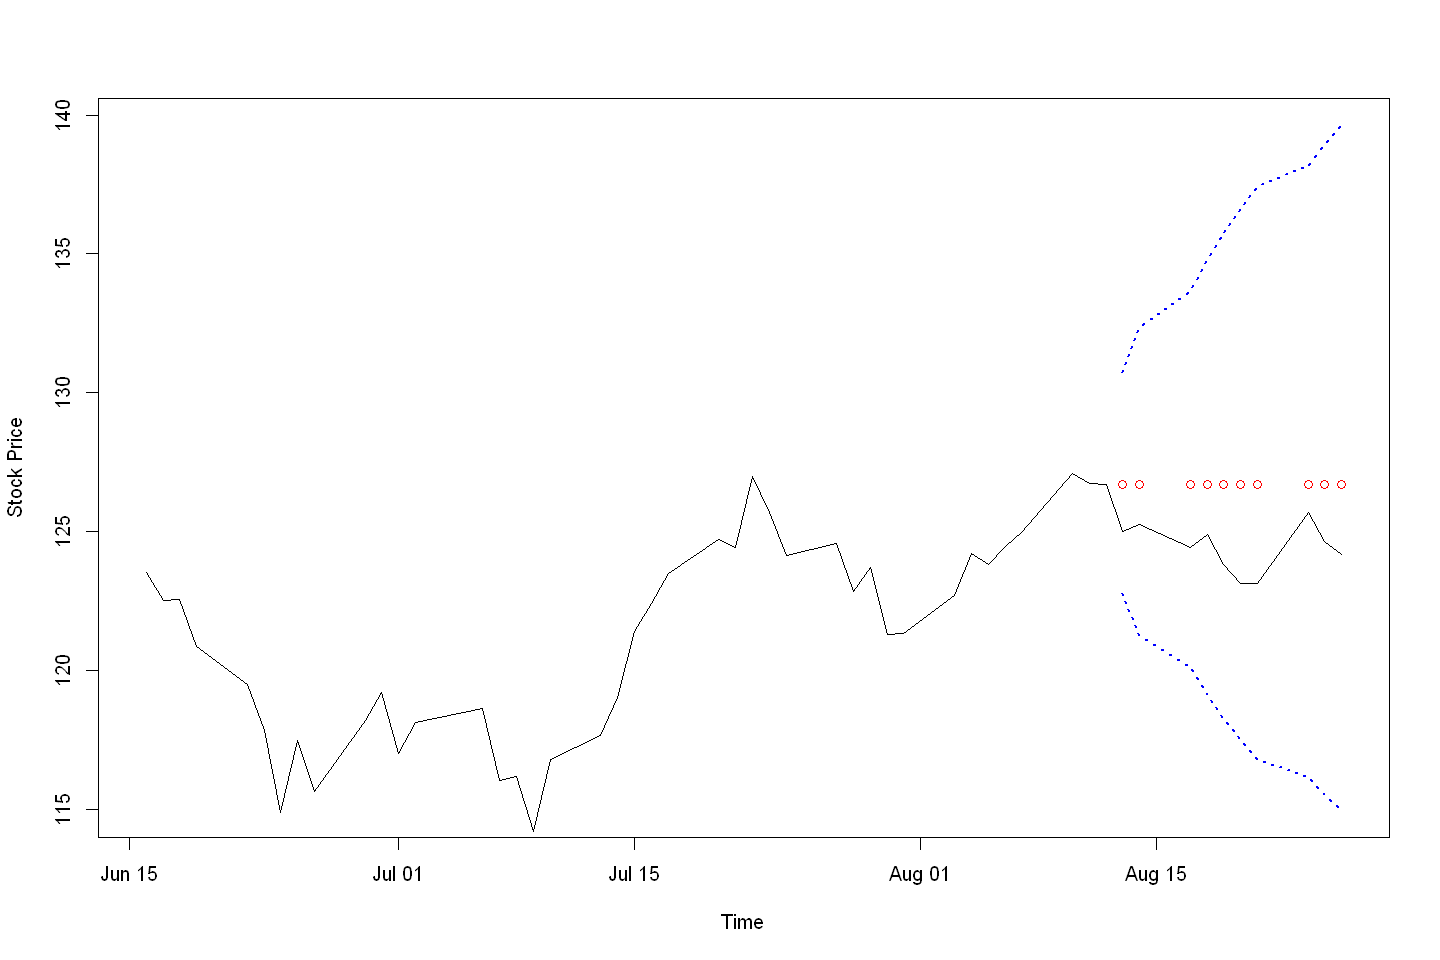

In [10]:
## Forecasting with ARIMA 
## 10 Days Ahead: 
n = length(ts.price)
nfit = n-10
outprice = arima(ts.price[1:nfit], order = c(porder,1,qorder),method = "ML")
outpred = predict(outprice,n.ahead=10)
ubound = outpred$pred+1.96*outpred$se
lbound = outpred$pred-1.96*outpred$se
ymin = min(exp(lbound))
ymax = max(exp(ubound))
plot(ibm.date[(n-50):n],exp(ts.price[(n-50):n]),type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Stock Price")
points(ibm.date[(nfit+1):n],exp(outpred$pred),col="red")
lines(ibm.date[(nfit+1):n],exp(ubound),lty=3,lwd= 2, col="blue")
lines(ibm.date[(nfit+1):n],exp(lbound),lty=3,lwd= 2, col="blue")

- The black line is the observed time series. 
- The red points are the predicted values along with the confidence bands in blue.
- All the observed values are within the confidence band. 
- The predicted values are somewhat closer to observed values, **except that they do not capture some of the variations in the stock price**. 
- **The confidence band is quite wide, widening as the lag increases also, indicating there is large volatility or uncertainty, in the prediction**.

### Prediction Accuracy

But how good are these predictions?

- We can compare the predictions derived from applying the predict() command based on the training data to the observed responses in the test data.
- In the real world, we do not have the observed responses at that time of making the predictions, and thus we cannot evaluate the prediction accuracy of a model. 
- But here, we first pretend we do not have the observed future time series values and predict based on the training data. 

Generally, the question “how good is the prediction?” comprises two separate aspects. 
- Firstly, measuring predictive accuracy per se. 
- Secondly, we compare various forecasting models. 

The most common reported measures of predicting accuracy are:

- Mean squared prediction error abbreviated MSPE and computed as the mean of the square differences between predicted and observed;
- Mean absolute prediction errors abbreviated MAE and computed as the mean of the absolute values of the differences between predicted and observed;
- Mean absolute percentage error abbreviated MAPE and computed as the mean of the absolute values of the differences scaled by the observed responses;
- Precision error abbreviated PM and computed as the ratio between MSPE and the sum of square differences between the response and the mean of the responses;
- Confidence Interval Measure abbreviated CIM computed as the number of predictions falling outside of the prediction intervals divided by the number of predictions made.

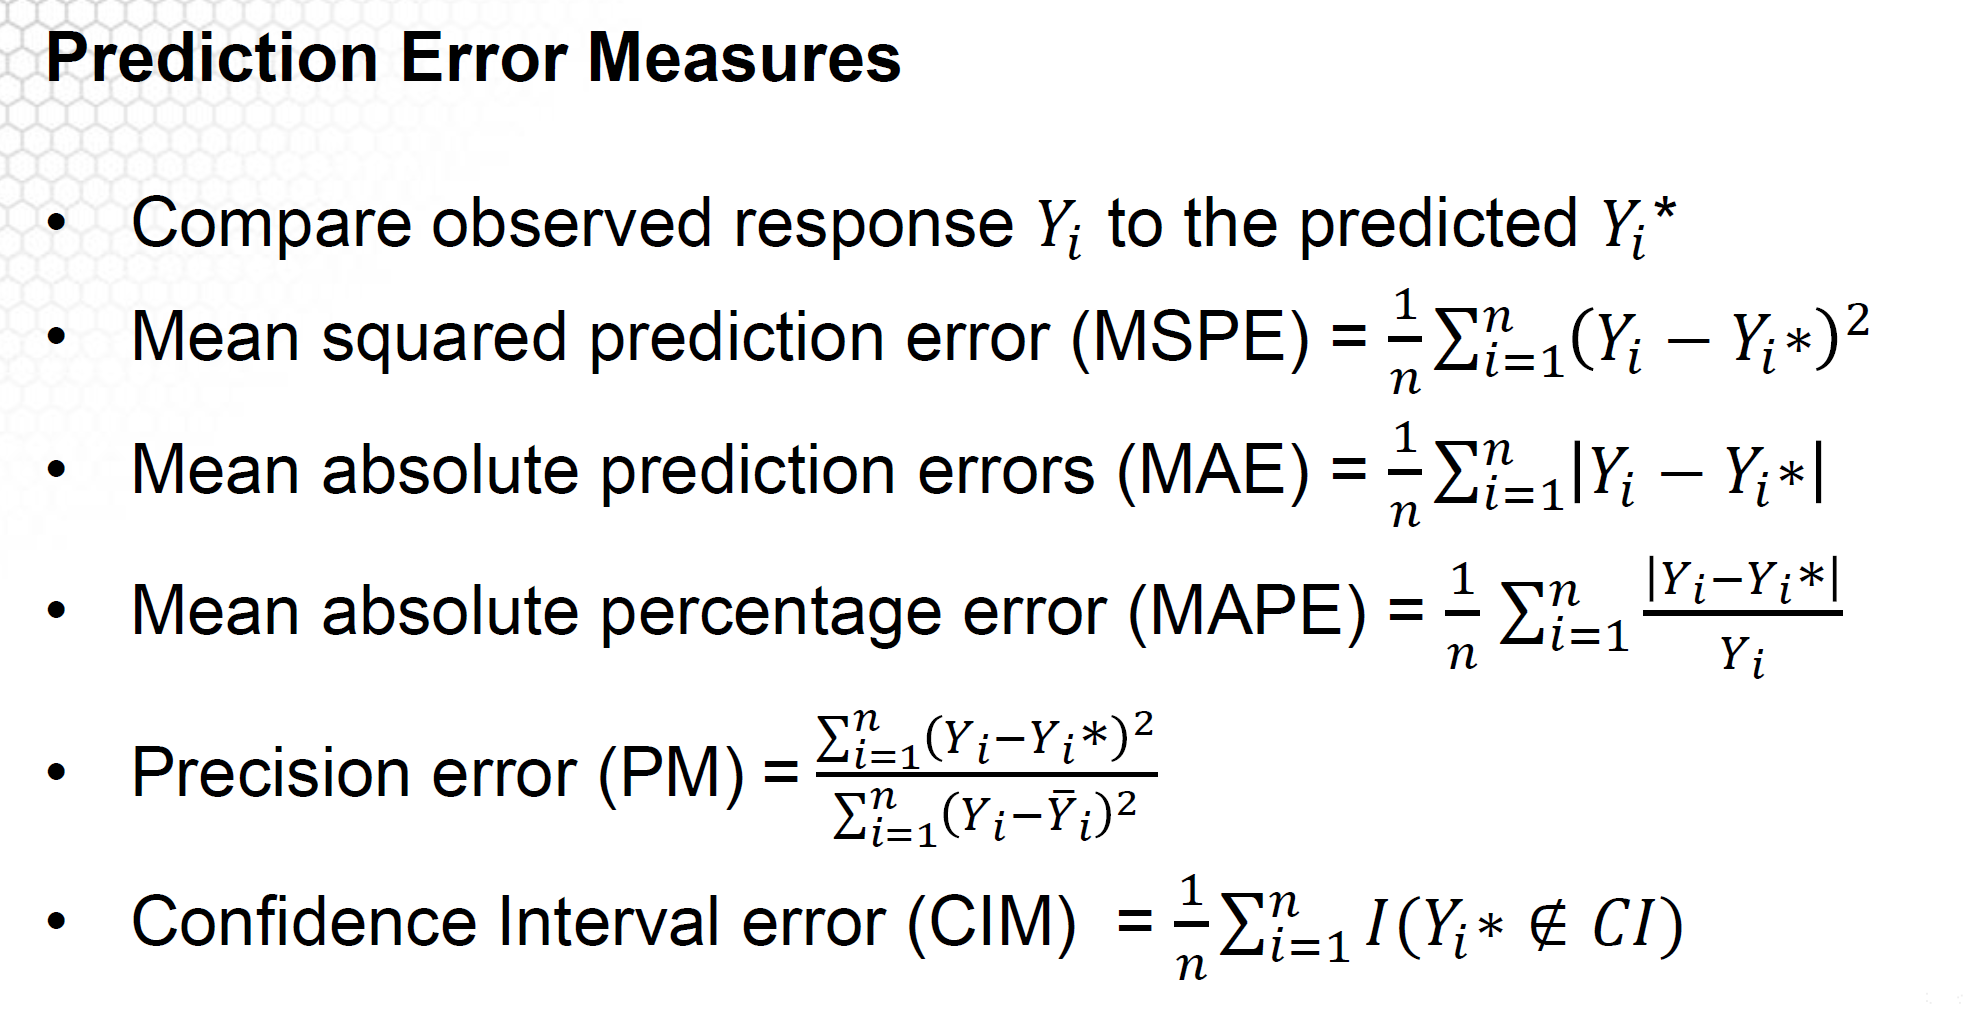

### Prediction Error Measure Insights

- MSPE is appropriate for evaluating prediction accuracy for models estimated by minimizing square prediction errors, but it depends on the scale of the time series data, and thus is sensitive to outliers.
- MAE is appropriate for evaluating prediction accuracy for models estimated by minimizing absolute prediction errors; similar to MSPE, it depends on scale, but it is robust to outliers.
- MAPE is appropriate to evaluate prediction accuracy for models estimated by minimizing absolute prediction errors, but unlike MAE, it does not depend on scale. It is also robust to outliers.
- Last, the precision error is appropriate for evaluating prediction accuracy for models estimated by minimizing square prediction errors. It also does not depend on scale. **The precision measure is reminiscent of the regression R squared. It can be interpreted as a proportion of the variability in the prediction versus the variability in the new data**.

**Generally, we prefer measures that are not scale dependent since they are comparable across models.** 

- Moreover, you will also need to understand what estimation approach was used in order to select the appropriate measures. 
- For example, many time series models are using similar estimation approaches to standard regression modeling, which are estimated by minimizing sum of least squares. Hence for such models, it is appropriate use the precision measure. 
- Using MLE assuming normal distribution implies a square prediction error hence again you should use the precision measure.
- However, if for example, you use MLE assuming t-distribution for the time series data, then MAPE is appropriate. 
- Thus, while MAPE is one of the most used prediction error measure, it is not appropriate to be used to evaluate prediction accuracy for most time series models.

### Prediction Accuracy: 10 Days Ahead

- Here I am comparing the 10-day ahead predictions with the observed time series values.
- Note that I took the exponential of the observed and predicted values since the data and the predictions are on the log-scale. 

In [11]:
## Compute Accuracy Measures
obsprice = exp(ts.price[(nfit+1):n]) 
predprice = exp(outpred$pred)
### Mean Squared Prediction Error (MSPE)
mean((predprice-obsprice)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(predprice-obsprice))
### Mean Absolute Percentage Error (MAPE)
mean(abs(predprice-obsprice)/obsprice)
### Precision Measure (PM)
sum((predprice-obsprice)^2)/sum((obsprice-mean(obsprice))^2)
### Does the observed data fall outside the prediction intervals?
sum(obsprice<exp(lbound))+sum(obsprice>exp(ubound))

[1] 5.816396

[1] 2.271224

[1] 0.01829638

[1] 8.840339

[1] 0

- The precision measure is 8.84, which measures that the proportion between the variability in the prediction and the variability in the new data. 
- **The closer this value is to zero, the better the prediction is. However, the prediction measure is quite large indicating poor performance in predicting the 10 days**.
- Last, I also note that all observed responses fall within the prediction intervals. 
- However, as I pointed out before, the prediction bands are quite large, indicating significant uncertainty in the predictions.

### ARIMA Forecasting: 1 rolling day vs 10 day ahead

- Let's also consider prediction of the 10 days, but this time on a rolling basis. 
- That is for each day, we fit the model with the entire time series up to that day and predict only one day ahead. 
- Apply this for each of the 10 days. To do this I used a loop command for i from 1 to 10 where each i corresponds to one different day. 
- We then save not only the prediction but also the prediction intervals.
- Last, I plug in the predictions based on this approach along with the observations of the time series.

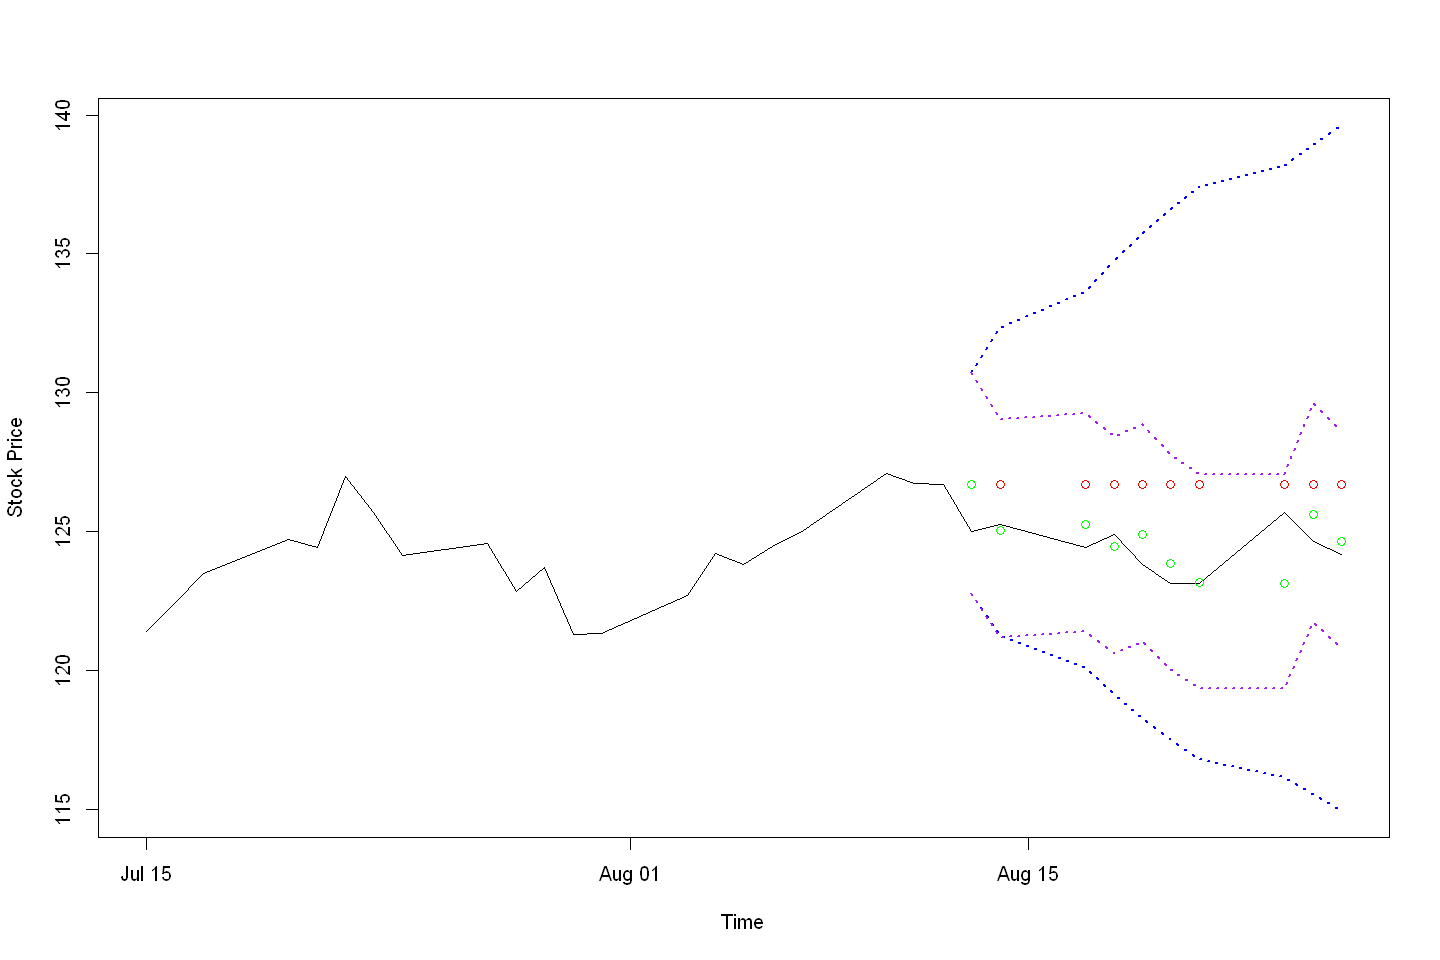

In [12]:
## Daily Prediction over a period of 10 days 
outpred.10 = NULL
ubound.10 = NULL
lbound.10 = NULL
n = length(ts.price)
for(i in 1:10){
   nfit = n-(10-i+1)
   outprice = arima(ts.price[1:nfit], order = c(porder,1,qorder),method = "ML")
   pred.1 = predict(outprice,n.ahead=1)
   outpred.10 = c(outpred.10,pred.1$pred)
   ubound.10 = c(ubound.10, pred.1$pred+1.96*pred.1$se)
   lbound.10 = c(lbound.10, pred.1$pred-1.96*pred.1$se)
  }

nfit = n-10
ymin = min(exp(c(lbound,lbound.10)))
ymax = max(exp(c(ubound,ubound.10)))
plot(ibm.date[(n-30):n],exp(ts.price[(n-30):n]),type="l", ylim=c(ymin,ymax), xlab="Time", ylab="Stock Price")
points(ibm.date[(nfit+1):n],exp(outpred$pred),col="red")
lines(ibm.date[(nfit+1):n],exp(ubound),lty=3,lwd= 2, col="blue")
lines(ibm.date[(nfit+1):n],exp(lbound),lty=3,lwd= 2, col="blue")
points(ibm.date[(nfit+1):n],exp(outpred.10),col="green")
lines(ibm.date[(nfit+1):n],exp(ubound.10),lty=3,lwd= 2, col="purple")
lines(ibm.date[(nfit+1):n],exp(lbound.10),lty=3,lwd= 2, col="purple")
legend(ibm.date[n-25],170,legend=c("1 Lag Ahead Prediction", "1 Lag Ahead Prediction Interval",
"10 Lags Ahead Prediction","10 Lags Ahead Prediction Interval" ),
       col=c("green","purple","red","blue"),pch=1,lty = c(0,3,0,3))


*The plot here compares the predictions from this approach, where the predictions for each of the 10 days were made on a rolling basis, to the prediction made 10 days ahead.*

- As expected, the predictions using the one day ahead, shown in green, are much closer to the observed time series values than the predictions from the 10 days ahead approach, shown in red. 
- Moreover, the confidence bands from the rolling basis predictions shown in purple are much tighter than for the 10 day ahead predictions. This is again expected since there is less uncertainty from one day to another, as compared from one day and looking 10 days ahead.

### Prediction Accuracy: 1-Day Ahead

Similar to the previous approach, we can also evaluate the accuracy of the prediction using accuracy measures.

In [13]:
## Compute Accuracy Measures 
predprice.10 = exp(outpred.10)
### Mean Squared Prediction Error (MSPE)
mean((predprice.10-obsprice)^2)
### Mean Absolute Prediction Error (MAE)
mean(abs(predprice.10-obsprice))
### Mean Absolute Percentage Error (MAPE)
mean(abs(predprice.10-obsprice)/obsprice)
### Precision Measure (PM)
sum((predprice.10-obsprice)^2)/sum((obsprice-mean(obsprice))^2)

### Does the observed data fall outside the prediction intervals?
sum(obsprice<exp(lbound.10))+sum(obsprice>exp(ubound.10))

[1] 1.294451

[1] 0.8947639

[1] 0.007171295

[1] 1.967435

[1] 0

- Now the precision measure reduced significantly to 1.49 versus 8.84 for the 10-day ahead predictions.

- While the prediction bands are tight for the 1-day rolling predictions, the observed values are all falling within the prediction bands. 

- The predictions using the one day ahead approach on a rolling basis are preferable, since the predictions are significantly better, however, **we cannot always use such an approach since there are situations when we want to predict 10 days ahead in the future rather than one day ahead. Generally, different models may be used for different lags ahead prediction**.

### End